# Latin Hypercube Sampling

The purpose of this notebook is to test out LHS sampling.

We find that the TPS problem alligns with the theory that LHS should reduce the number of samples needed to get 'good' information for GPR.

In [1]:
from scipy.stats.qmc import LatinHypercube

import numpy as np
import matplotlib.pyplot as plt

In [2]:
engine = LatinHypercube(d=2)
sample = engine.random(n=1000)

In [3]:
from matplotlib.cm import datad
def create_data(sample):
  """
  Regardless of dimension, splitting the array into lists
  """

  d = {}

  for i in range(len(sample[0])):
    d["{0}".format(i)] = []

  keys = d.keys()

  for key in list(keys):
    for i in range(len(sample)):
      d[key] += [sample[i][int(key)]]

  return d

# 3-D LHS

https://jakevdp.github.io/PythonDataScienceHandbook/04.12-three-dimensional-plotting.html

In [4]:
from mpl_toolkits import mplot3d

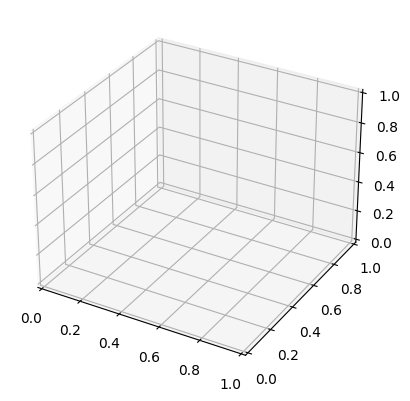

In [5]:
fig = plt.figure()
ax = plt.axes(projection='3d')

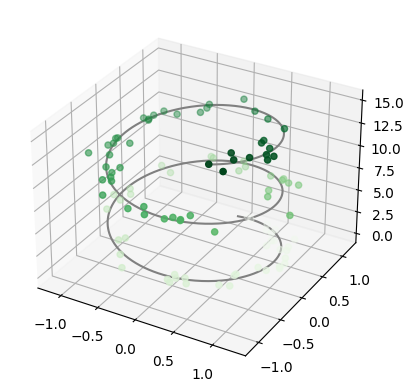

In [6]:
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
zline = np.linspace(0, 15, 1000)
xline = np.sin(zline)
yline = np.cos(zline)
ax.plot3D(xline, yline, zline, 'gray')

# Data for three-dimensional scattered points
zdata = 15 * np.random.random(100)
xdata = np.sin(zdata) + 0.1 * np.random.randn(100)
ydata = np.cos(zdata) + 0.1 * np.random.randn(100)
ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greens')

In [7]:
engine = LatinHypercube(d=3)
sample = engine.random(n=100)

xdata,ydata,zdata = create_data(sample)

In [8]:
engine = LatinHypercube(d=14)
sample = engine.random(n=1000)
sample = create_data(sample)

In [9]:
import pandas as pd
sample_df = pd.DataFrame(sample)

In [10]:
url = 'https://raw.githubusercontent.com/benkim1226/footballdata/master/simulated_data_1000.csv'
data = pd.read_csv(url, index_col = 0)

In [11]:
a = []
b = []

for column in data.columns:
  b.append(max(data[column]))
  a.append(min(data[column]))

In [12]:
for i in range(len(sample_df.columns)):
  sample_df.iloc[:,i] = a[i] +(b[i] - a[i])*sample_df.iloc[:,i]

In [13]:
from google.colab import files
sample_df.to_csv('LHS_IVs.csv')
files.download('LHS_IVs.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Standardizing the LHS

For comparison with the other data

Importing from github

In [14]:
LHS_url = 'https://raw.githubusercontent.com/benkim1226/footballdata/master/LHS_complete.csv'
LHS_data = pd.read_csv(LHS_url, index_col = 0)
LHS_data = LHS_data.reset_index()

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaled_LHS = scaler.fit_transform(LHS_data)
scaled_LHS = pd.DataFrame(scaled_LHS)

url = 'https://raw.githubusercontent.com/benkim1226/footballdata/master/simulated_data_1000.csv'
data = pd.read_csv(url, index_col = 0)

scaled_data = scaler.fit_transform(data)
scaled_data = pd.DataFrame(scaled_data)


Graphs!

<function matplotlib.pyplot.show(close=None, block=None)>

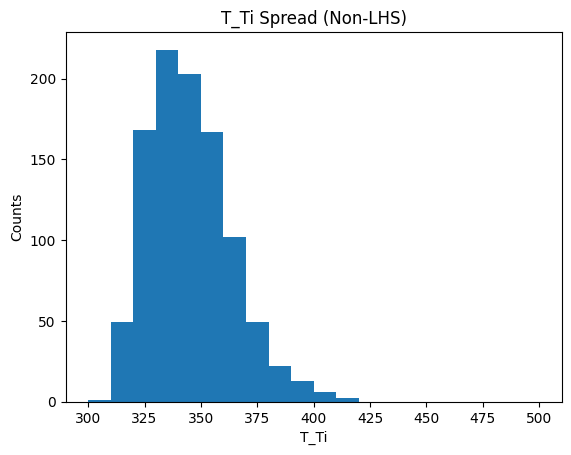

In [15]:
import matplotlib.pyplot as plt


plt.hist(data['simulation_values'], bins=20, range=(300, 500), density=False)
plt.xlabel('T_Ti')
plt.ylabel('Counts')
plt.title('T_Ti Spread (Non-LHS)')

plt.show


<function matplotlib.pyplot.show(close=None, block=None)>

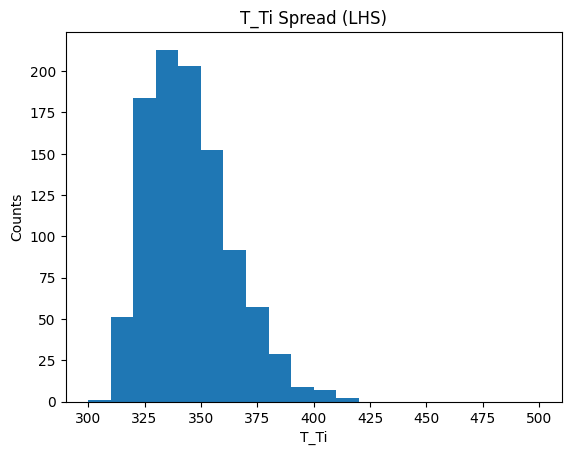

In [16]:
plt.hist(LHS_data['simulation_values'], bins=20,range=(300, 500), density=False) # LHS_data['simulation_values']
plt.xlabel('T_Ti')
plt.ylabel('Counts')
plt.title('T_Ti Spread (LHS)')

plt.show


# COMPARISON OF NON-LHS AND LHS



In [17]:
# Set up
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, RationalQuadratic, ExpSineSquared, DotProduct, Matern, WhiteKernel
from sklearn.metrics import mean_absolute_error
import random
# np.random.seed(1226)

In [24]:
# FUNCTION

sample_sizes = list(np.around((np.logspace(1, 2.7, 10)),0)) # USE LOGISTICAL SAMPLE SIZES
sample_sizes = [int(x) for x in sample_sizes]

MSE_scores = []
MSE_stds = []

GPR_scores = []

MAE_train = []
MAE_test = []
MAE_train_stds = []
MAE_test_stds = []

def sample_test_func(df):

  for s in sample_sizes:

    indexes = random.sample(range(0, len(df)), s)
    sample_data = df.loc[indexes]

    X = sample_data.iloc[:,0:13]
    y = sample_data.iloc[:,14]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    constant = 1
    length_scale_array = np.array([1]*len(X.columns))
    kernel = constant * RBF(length_scale = length_scale_array, length_scale_bounds = (1e-3, 1e3)) # How high should this bound be?

    gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
    gpr.fit(X_train, y_train)

    y_train_pred, std_train_pred  = gpr.predict(X_train, return_std=True)
    y_test_pred, std_test_pred    = gpr.predict(X_test, return_std=True)

    MAE_train.append(mean_absolute_error(y_train, y_train_pred))
    MAE_test.append(mean_absolute_error(y_test, y_test_pred))

    MAE_train_stds.append(mean_absolute_error(y_train, y_train_pred+ 1.96*std_train_pred))
    MAE_test_stds.append(mean_absolute_error(y_test, y_test_pred + 1.96*std_test_pred ))

In [ ]:
sample_test_func(scaled_LHS)

MSE_scores_LHS = MSE_scores.copy()
MSE_stds_LHS = MSE_stds.copy()

GPR_scores_LHS = GPR_scores.copy()

MAE_train_LHS = MAE_train.copy()
MAE_test_LHS = MAE_test.copy()
MAE_test_stds_LHS = MAE_test_stds.copy()
MAE_train_stds_LHS = MAE_train_stds.copy()



In [ ]:
MAE_train = []
MAE_test = []
MAE_train_stds = []
MAE_test_stds = []

sample_test_func(scaled_data)

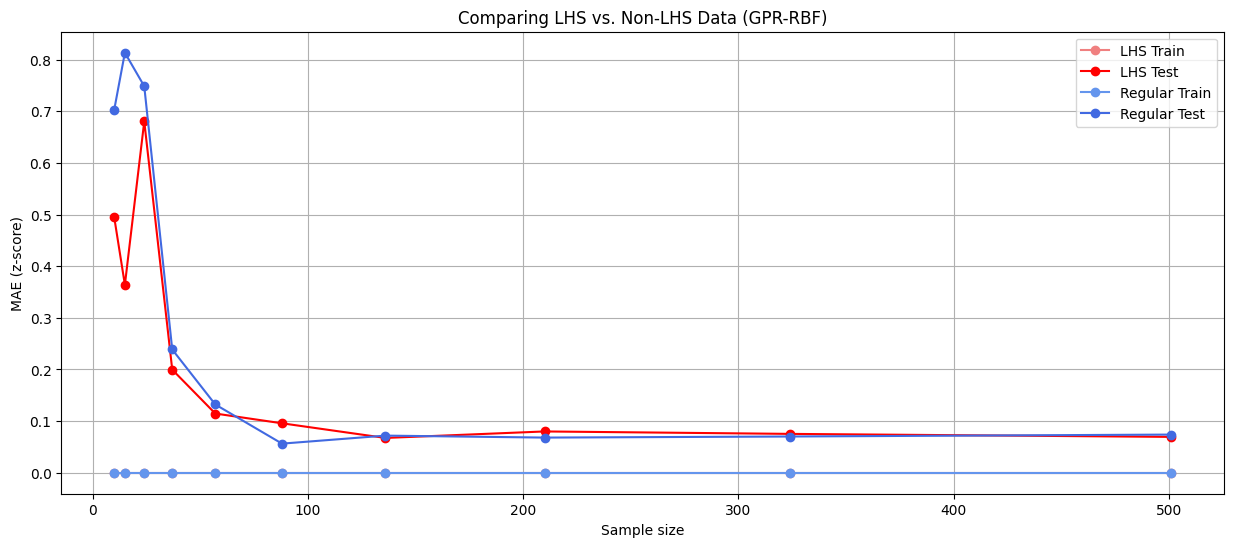

In [28]:
plt.figure(figsize=(15,6))

plt.plot(sample_sizes, MAE_train_LHS, 'o-', color='lightcoral', label='LHS Train')
plt.plot(sample_sizes, MAE_test_LHS, 'o-', color='red', label='LHS Test')
plt.plot(sample_sizes, MAE_train, 'o-', color='cornflowerblue', label='Regular Train')
plt.plot(sample_sizes, MAE_test, 'o-', color='royalblue', label='Regular Test')

plt.legend()
plt.grid()
plt.xlabel('Sample size')
plt.ylabel('MAE (z-score)')
plt.title('Comparing LHS vs. Non-LHS Data (GPR-RBF)')
plt.show()